## RROC scattering rate

**Resonance Raman optical cycling for high-fidelity fluorescence detection of molecules**   
J. C. Shaw, J. C. Schnaubelt, and D. J. McCarron  
Phys. Rev. Research 3, L042041.  
DOI: https://doi.org/10.1103/PhysRevResearch.3.L042041

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as cts
import pylcp_local as pylcp

In [45]:
Gamma = 6.6 # MHz

# spectroscopic parameters from JFB thesis Table 2.8
H0_X_v0, mu_p_X_v0, U_X_v0, basis_X_v0 = pylcp.hamiltonians.XFmolecules.Xstate(
    N = 1, I = 1/2, 
    gamma = 74.7950/Gamma, # spin-rotation coupling for v=0 N=1
    b = 97.0827/Gamma, c = 30.2675/Gamma, CI = 0.0023/Gamma, q0 = 0, q2 = 0, # hyperfine parameters for v=0 N=1
    muB = cts.value('Bohr magneton in Hz/T')/1e6*1e-4/Gamma, 
    muN = cts.m_e/cts.m_p*cts.value('Bohr magneton in Hz/T')/1e6*1e-4/Gamma,
    return_basis = True
    )
E_X_v0 = np.unique(np.diag(H0_X_v0))

# spectroscopic parameters from JFB thesis Table 2.8
H0_X_v1, mu_p_X_v1, U_X_v1, basis_X_v1 = pylcp.hamiltonians.XFmolecules.Xstate(
    N = 1, I = 1/2, 
    gamma = 74.3397/Gamma, # spin-rotation coupling for v=0 N=1
    b = 95.9155/Gamma, c = 31.1105/Gamma, CI = 0.0023/Gamma, q0 = 0, q2 = 0, # hyperfine parameters for v=0 N=1
    muB = cts.value('Bohr magneton in Hz/T')/1e6*1e-4/Gamma, 
    muN = cts.m_e/cts.m_p*cts.value('Bohr magneton in Hz/T')/1e6*1e-4/Gamma,
    return_basis = True
    )
E_X_v1 = np.unique(np.diag(H0_X_v1))

H0_A_v0, mu_p_A_v0, basis_A_v0 = pylcp.hamiltonians.XFmolecules.Astate(
    J = 1/2, I = 1/2, P = +1, 
    a = 0, b = 0, c = 0, # related to hyperfine structure
    muB = cts.value('Bohr magneton in Hz/T')/1e6*1e-4/Gamma, 
    muN = cts.m_e/cts.m_p*cts.value('Bohr magneton in Hz/T')/1e6*1e-4/Gamma,
    # glprime = -0.26395, greprime=4.37e-4, # extra contribution from electron to g-factor
    return_basis = True
    )
E_A_v0 = np.unique(np.diag(H0_A_v0))

dijp_X_v0_A_v0 = pylcp.hamiltonians.XFmolecules.dipoleXandAstates(
    basis_X_v0, basis_A_v0, I = 1/2, S = 1/2, UX = U_X_v0
    )

dijp_X_v1_A_v0 = pylcp.hamiltonians.XFmolecules.dipoleXandAstates(
    basis_X_v1, basis_A_v0, I = 1/2, S = 1/2, UX = U_X_v1
    )

# hamiltonian = pylcp.hamiltonian(H0_X_v0, H0_A_v0, mu_p_X_v0, mu_p_A_v0, dijp_X_v0_A_v0)
hamiltonian = pylcp.hamiltonian()

# H0 includes the energy of the states
hamiltonian.add_H_0_block('X_v0', H0_X_v0) 
hamiltonian.add_H_0_block('X_v1', H0_X_v1)
hamiltonian.add_H_0_block('A_v0', H0_A_v0)

# mu_p includes the magnetic dipole moment of the states, so muB is not needed as an input. 
# 'p' and 'q' labelling is mixed, which is confusing. 'p' is for lab frame indices, and 'q' is for molecule frame indices. 
# It think it should all be 'p' here.
hamiltonian.add_mu_q_block('X_v0', mu_p_X_v0) 
hamiltonian.add_mu_q_block('X_v1', mu_p_X_v1)
hamiltonian.add_mu_q_block('A_v0', mu_p_A_v0)

# gamma is used to specify the decay rate in this transition. 
# Rabi frequency is only determined by laser parameters in pylcp. 
# Again, the 'p' and 'q' labelling is mixed.
hamiltonian.add_d_q_block('X_v0', 'A_v0', dijp_X_v0_A_v0, gamma=1)
hamiltonian.add_d_q_block('X_v1', 'A_v0', dijp_X_v1_A_v0, gamma=0.01641) # branching ratio from JFB thesis Table 2.13


In [46]:
omega_X_v0_A_v0 = 2 * np.pi * (cts.c/663e-9) # Hz, resonant frequency of the X(v=0)->A(v=0) transition
Isat_X_v0_A_v0 = cts.hbar * omega_X_v0_A_v0**3 * (2*np.pi*Gamma*1e6) / (12*np.pi*cts.c**2) / 10 # in mW/cm^2, saturation intensity for X(v=0)->A(v=0) transition, 2*np.pi*Gamma*1e6 is the actual Gammam value = 2pi*6.6e6 Hz
# print(f"I_sat (X(v=0)->A(v=0)) = {Isat_X_v0_A_v0 :.3f} mW/cm^2.")

laser_power_X_v0_A_v0 = {'F1D': 10, 'F0': 10, 'F1Ublue':10, 'F1Ured':10, 'F2':80} # mW, sinlge laser beam power (single pass through MOt chamber)
laser_beam_sigma = 3.5e-1 # cm, sigma of laser beam size
I_peak_X_v0_A_v0 = {key: val / (2*np.pi*laser_beam_sigma**2) for key, val in laser_power_X_v0_A_v0.items()} # mW/cm^2, peak intensity of gaussian beam (single pass)
s_peak_X_v0_A_v0 = {key: val / Isat_X_v0_A_v0 for key, val in I_peak_X_v0_A_v0.items()} # saturation parameter at the center of the beam

laser_detuning_X_v0_A_v0 = {'F1D': -6, 'F0': -3, 'F1Ublue': +6, 'F1Ured': -6, 'F2': -3} # MHz, laser detuning
laser_detuning_X_v0_A_v0 = {key: val / Gamma for key, val in laser_detuning_X_v0_A_v0.items()} # in units of Gamma

laserBeams = {}

laserBeams['X_v0->A_v0'] = pylcp.laserBeams()
laserBeams['X_v0->A_v0'] += pylcp.conventional3DMOTBeams(s = s_peak_X_v0_A_v0['F1D'], 
                                                         delta = (E_A_v0[-1]-E_X_v0[0])+laser_detuning_X_v0_A_v0['F1D'], 
                                                         pol = +1, 
                                                         beam_type = pylcp.infinitePlaneWaveBeam) # F1 down
laserBeams['X_v0->A_v0'] += pylcp.conventional3DMOTBeams(s = s_peak_X_v0_A_v0['F0'], 
                                                         delta = (E_A_v0[-1]-E_X_v0[1])+laser_detuning_X_v0_A_v0['F0'],
                                                         pol = +1,
                                                         beam_type = pylcp.infinitePlaneWaveBeam) # F0
laserBeams['X_v0->A_v0'] += pylcp.conventional3DMOTBeams(s = s_peak_X_v0_A_v0['F1Ublue'], 
                                                         delta = (E_A_v0[-1]-E_X_v0[2])+laser_detuning_X_v0_A_v0['F1Ublue'],
                                                         pol = +1,
                                                         beam_type = pylcp.infinitePlaneWaveBeam) # F1 up blue
laserBeams['X_v0->A_v0'] += pylcp.conventional3DMOTBeams(s = s_peak_X_v0_A_v0['F1Ured'], 
                                                         delta = (E_A_v0[-1]-E_X_v0[2])+laser_detuning_X_v0_A_v0['F1Ured'],
                                                         pol = -1,
                                                         beam_type = pylcp.infinitePlaneWaveBeam) # F1 up red
laserBeams['X_v0->A_v0'] += pylcp.conventional3DMOTBeams(s = s_peak_X_v0_A_v0['F2'], 
                                                         delta = (E_A_v0[-1]-E_X_v0[3])+laser_detuning_X_v0_A_v0['F2'],
                                                         pol = -1,
                                                         beam_type = pylcp.infinitePlaneWaveBeam) # F2



In [47]:
magField = pylcp.constantMagneticField([0, 0, 0]) # gauss

Completed in 13.95 s.                                               


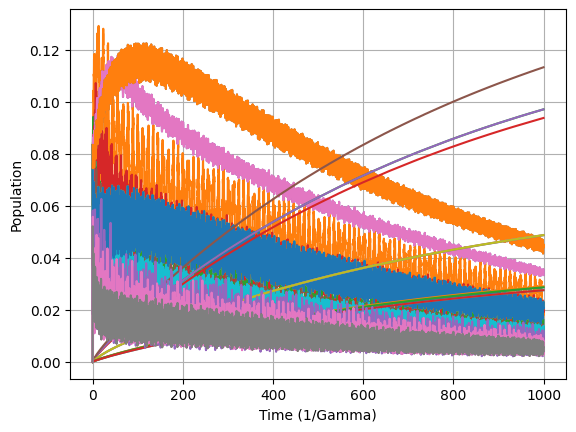

In [48]:
obe = pylcp.obe(laserBeams, magField, hamiltonian, include_mag_forces=True)
init_population = np.array([1] * H0_X_v0.shape[0] + [0] * H0_X_v1.shape[0] + [0] * H0_A_v0.shape[0]) # initial populaton in each state
init_population = init_population.astype('float') / init_population.sum()  # Normalize the populations

t_eval = np.arange(0, 1000, 0.1) # in units of 1/Gamma
obe.set_initial_rho_from_populations(init_population)
obe.evolve_density([t_eval[0], t_eval[-1]], t_eval=t_eval, progress_bar=True)
population = np.array([[np.abs(obe.sol.rho[i, i, j]) for i in range(obe.sol.rho.shape[0])] for j in range(obe.sol.rho.shape[-1])])

plt.plot(obe.sol.t, population)
plt.xlabel('Time (1/Gamma)')
plt.ylabel('Population')
plt.grid()
plt.show()


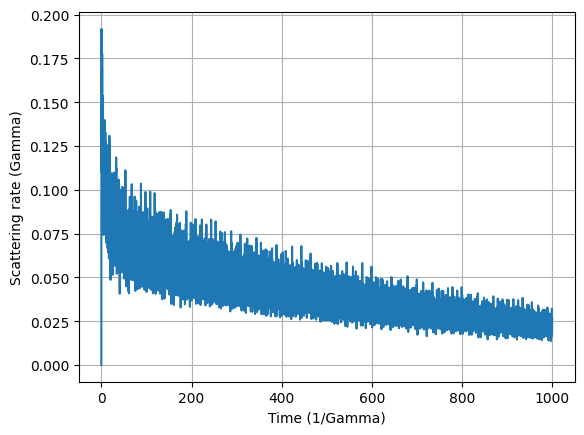

In [49]:
scatter_rate_observable = np.diagflat([0] * H0_X_v0.shape[0] + [0] * H0_X_v1.shape[0] + [1] * H0_A_v0.shape[0]) # an observable whose expectation value is the total excited state population (i.e. a diagonal matrix with 1's only on the excited state diagonal)
scatter_rate = obe.observable(scatter_rate_observable)

plt.plot(obe.sol.t, scatter_rate)
plt.xlabel('Time (1/Gamma)')
plt.ylabel('Scattering rate (Gamma)')
plt.grid()
plt.show()